# Functions

In [93]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel

from os import listdir
from os.path import isdir, join

def visualize_classifier_data(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   

    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    all_dataset_stats = [f for f in listdir(join(data_path, 'dataset_stats')) if isdir(join(join(data_path, 'dataset_stats'), f))]
    results = dict()
    for dataset_dir in all_dataset_stats:
        all_splits_per_dataset_path = join(join(data_path, 'dataset_stats'), dataset_dir)
        all_dirs = [f for f in listdir(all_splits_per_dataset_path) if isdir(join(all_splits_per_dataset_path, f))]

        for dir_path in all_dirs:
            with open(join(join(join(data_path, 'dataset_stats'), dataset_dir), dir_path+'/stats.json'), 'r') as f:
                curr_stat = json.load(f)
                if dataset_dir not in results.keys():
                    results[dataset_dir] = [curr_stat['number_connected_components']]
                else:
                    results[dataset_dir].append(curr_stat['number_connected_components'])

    stats_dataset_name, stats_dataset_mean, stats_dataset_std = [], [], []
    for dataset_name, stats in results.items():
        stats_dataset_name.append(dataset_name)
        stats_dataset_mean.append(np.mean(stats))
        stats_dataset_std.append(np.std(stats))

    df = pd.DataFrame({
            'Dataset': [(dataset_names[name] + f' ({np.round(stats_dataset_mean[i], 1)})') for i, name in enumerate(stats_dataset_name)],
            'Number of components': np.round(stats_dataset_mean, 4),
            'std': stats_dataset_std
        })

    sns.set_theme()
    stats_bar_plot = sns.barplot(x='Dataset', y='Number of components', data=df, color='#05F140')
    for i, (mean, std) in enumerate(zip(df['Number of components'], df['std'])):
            stats_bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            # Optionally annotate the bars with the exact mean values
            if annotate:
                stats_bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)

    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=10)
    plt.title(f'Number of connected components in training graphs')
    plt.savefig(f'{fig_path}/train_connected_components_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()

    for dataset_dir in all_dataset_dirs:
        all_models_per_dataset_path = join(data_path, dataset_dir)
    
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]
        # print(all_dirs)

        results = dict()
        for dir_path in all_dirs:
            if True: #'relu' not in dir_path and 'gelu' not in dir_path and 'leaky_relu' not in dir_path and 'nw' not in dir_path:
                with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    if tuple([curr_res['model_name'], ft]) not in results.keys():
                        results[tuple([curr_res['model_name'], ft])] = []
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                    else:
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

        # print(results)

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            # print(len(metrics))
            classifiers[tuple([name, ft])] = []
            classifiers[tuple([name, ft])].append(np.mean(metrics))
            classifiers[tuple([name, ft])].append(np.std(metrics))
            classifiers[tuple([name, ft])].append(metrics)

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            all_fts.append(ft)
            classifier_names.append(name)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        
        # Create a DataFrame for easier plotting with seaborn
        print('classifiers', len(classifier_names), len(means))
        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        # Optionally sort the bars by their mean values
        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        all_pvalues = []
        for i in range(df.shape[0]):
            if i == 0:
                all_pvalues.append(1)
            else:
                statistic, p_value = ttest_ind(df.iloc[0, 4], df.iloc[i, 4], equal_var=False)
                all_pvalues.append(p_value)

        n_tests = len(all_pvalues)
        all_pvalues = [p * n_tests for p in all_pvalues]



        # print(df)

        # Plotting
        if plot_best_per_class:
            plt.figure(figsize=(6, 6))
        else:
            plt.figure(figsize=(16, 6))
        # sns.set(style="whitegrid")
        sns.set_theme()
        
        cols, hue_names = [], []
        color_model_scheme = {'GNN graph based':'#05F140', 'GNN one hot':'#253957', 'MLP':'#FFB400', 'Heuristics':'#00B4D8', 'Community detection': '#EF233C'}#9B7EDE #FFDF64 #5FBFF9 #FF595E
        for index, row in df.iterrows():
            # print(row)
            model_name = row['Classifier']
            ft = row['feature_type']
            if 'MLP' in model_name:
                cols.append(color_model_scheme['MLP'])
                hue_names.append('MLP')
            elif ft == 'graph_based':
                cols.append(color_model_scheme['GNN graph based'])
                hue_names.append('GNN graph based')
            elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                cols.append(color_model_scheme['Heuristics'])
                hue_names.append('Heuristics')
            elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                cols.append(color_model_scheme['Community detection'])
                hue_names.append('Community detection')
            else:
                cols.append(color_model_scheme['GNN one hot'])
                hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        for u_n in np.unique(hue_names):
            current_df = df.loc[np.array(hue_names) == u_n]
            one_best_model_per_class_df.append(current_df.loc[[current_df['Mean'].idxmax()]])

        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]
        print(one_best_model_per_class_df)

        if plot_best_per_class:
            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                # print(row)
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristics'])
                    one_best_model_per_class_hue_names.append('Heuristics')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')
            bar_plot = sns.barplot(x=one_best_model_per_class_df.index, y=one_best_model_per_class_df.Mean, data=one_best_model_per_class_df, palette=color_model_scheme, hue=one_best_model_per_class_hue_names)
        else:
            bar_plot = sns.barplot(x=df.index, y=df.Mean, data=df, palette=color_model_scheme, hue=hue_names)  # , palette="viridis")

        # Collect all bars from all containers
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])

        # Extract the sorted bars
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching to the first six bars as they appear in the plot
        for i, bar in enumerate(sorted_bars):
            if all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])

        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(bar_plot.containers[i], label_type='center', rotation=90, color='white', fontsize=6)
        if plot_best_per_class:
            bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier)
        else:
            bar_plot.set_xticklabels(df.Classifier)
        # print(bar_plot.containers[0])
        
        if plot_best_per_class:
            # Adding error bars
            for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
                bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

                # Optionally annotate the bars with the exact mean values
                if annotate:
                    bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)
        else:
            # Adding error bars
            for i, (mean, std) in enumerate(zip(df['Mean'], df['StdDev'])):
                bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

                # Optionally annotate the bars with the exact mean values
                if annotate:
                    bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)


        
                
        
        # for k, v in color_model_scheme.items():
        #     if k != 'Community detection':
        #         plt.scatter([],[], c=v, label=k)

        if class_plot_only is None:
            plt.title(f'Model performance for dataset {dataset_names[dataset_dir]}')
        else:
            plt.title(f'Model performance for {dataset_dir} (class {class_plot_only})')
        plt.xlabel('Model')
        plt.ylabel('F1-macro score')
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=8)  # Rotate x-axis labels for better readability
        ax = plt.gca()
        for i in range(len(ax.get_xticklabels())):
            if ax.get_xticklabels()[i].get_text() in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                break
            else:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        if plot_best_per_class:
            plt.ylim(np.min(one_best_model_per_class_df['Mean'])-0.05, 1.05)
        plt.legend(fontsize='small')
        plt.tight_layout()  # Adjust the layout to make room for the rotated labels
        if fig_path is not None:
            if class_plot_only is None:
                plt.savefig(f'{fig_path}/{dataset_dir}_mask_percent_{mask_percent}.pdf', bbox_inches="tight")
            else:
                plt.savefig(f'{fig_path}/{dataset_dir}_mask_percent_{mask_percent}_{class_plot_only}.pdf', bbox_inches="tight")
        plt.show()


In [55]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel

from os import listdir
from os.path import isdir, join

def visualize_classifier_data(data_path, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, 
                              plot_best_per_class=True):   

    dataset_names = {'Western-Europe':'WE', 'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Scandinavia': 'SC'}

    all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
    if dataset_plot_only is not None:
        all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

    all_dataset_stats = [f for f in listdir(join(data_path, 'dataset_stats')) if isdir(join(join(data_path, 'dataset_stats'), f))]
    results = dict()
    for dataset_dir in all_dataset_stats:
        all_splits_per_dataset_path = join(join(data_path, 'dataset_stats'), dataset_dir)
        all_dirs = [f for f in listdir(all_splits_per_dataset_path) if isdir(join(all_splits_per_dataset_path, f))]

        for dir_path in all_dirs:
            with open(join(join(join(data_path, 'dataset_stats'), dataset_dir), dir_path+'/stats.json'), 'r') as f:
                curr_stat = json.load(f)
                if dataset_dir not in results.keys():
                    results[dataset_dir] = [curr_stat['number_connected_components']]
                else:
                    results[dataset_dir].append(curr_stat['number_connected_components'])

    stats_dataset_name, stats_dataset_mean, stats_dataset_std = [], [], []
    for dataset_name, stats in results.items():
        stats_dataset_name.append(dataset_name)
        stats_dataset_mean.append(np.mean(stats))
        stats_dataset_std.append(np.std(stats))

    df = pd.DataFrame({
            'Dataset': [(dataset_names[name] + f' ({np.round(stats_dataset_mean[i], 1)})') for i, name in enumerate(stats_dataset_name)],
            'Number of components': np.round(stats_dataset_mean, 4),
            'std': stats_dataset_std
        })

    sns.set_theme()
    stats_bar_plot = sns.barplot(x='Dataset', y='Number of components', data=df, color='#05F140')
    for i, (mean, std) in enumerate(zip(df['Number of components'], df['std'])):
            stats_bar_plot.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            # Optionally annotate the bars with the exact mean values
            if annotate:
                stats_bar_plot.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=6)

    plt.xticks(rotation=90, ha='right', rotation_mode='anchor', verticalalignment='center', fontsize=10)
    plt.title(f'Number of connected components in training graphs')
    plt.savefig(f'{fig_path}/train_connected_components_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()

    # Set up a new 2x2 layout figure for combined plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    ax_idx = 0
    all_handles, all_labels = [], []

    for dataset_dir in all_dataset_dirs:
        all_models_per_dataset_path = join(data_path, dataset_dir)
    
        all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

        results = dict()
        for dir_path in all_dirs:
            if True:
                with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                    curr_res = json.load(f)
                    if 'graph_based' in dir_path:
                        ft = 'graph_based'
                    elif 'one_hot' in dir_path:
                        ft = 'one_hot'
                    else:
                        ft = ''
                    if tuple([curr_res['model_name'], ft]) not in results.keys():
                        results[tuple([curr_res['model_name'], ft])] = []
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                    else:
                        if class_plot_only is None:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                        else:
                            results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

        classifiers = dict()
        for name_ft, metrics in results.items():
            name, ft = name_ft
            classifiers[tuple([name, ft])] = []
            classifiers[tuple([name, ft])].append(np.mean(metrics))
            classifiers[tuple([name, ft])].append(np.std(metrics))
            classifiers[tuple([name, ft])].append(metrics)

        classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
        
        for name_ft, metrics in classifiers.items():
            name, ft = name_ft
            all_fts.append(ft)
            classifier_names.append(name)
            means.append(metrics[0])
            std_devs.append(metrics[1])
            all_metrics.append(metrics[2])

        df = pd.DataFrame({
            'Classifier': classifier_names,
            'Mean': np.round(means, 4),
            'StdDev': std_devs,
            'feature_type': all_fts,
            'all_metrics': all_metrics
        })

        if sort_bars:
            df = df.sort_values('Mean', ascending=False)

        df = df.reset_index(drop=True)

        cols, hue_names = [], []
        color_model_scheme = {'GNN graph based':'#05F140', 'GNN one hot':'#253957', 'MLP':'#FFB400', 'Heuristic':'#00B4D8', 'Community detection': '#EF233C'}
        for index, row in df.iterrows():
            model_name = row['Classifier']
            ft = row['feature_type']
            if 'MLP' in model_name:
                cols.append(color_model_scheme['MLP'])
                hue_names.append('MLP')
            elif ft == 'graph_based':
                cols.append(color_model_scheme['GNN graph based'])
                hue_names.append('GNN graph based')
            elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                cols.append(color_model_scheme['Heuristic'])
                hue_names.append('Heuristic')
            elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                cols.append(color_model_scheme['Community detection'])
                hue_names.append('Community detection')
            else:
                cols.append(color_model_scheme['GNN one hot'])
                hue_names.append('GNN one hot')

        one_best_model_per_class_df = []
        one_best_model_hue_names = []
        for u_n in np.unique(hue_names):
            current_df = df.loc[np.array(hue_names) == u_n]
            best_model = current_df.loc[[current_df['Mean'].idxmax()]]
            one_best_model_per_class_df.append(best_model)
            one_best_model_hue_names.append(u_n)

        one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            # Optionally sort the bars by their mean values
            if sort_bars:
                one_best_model_per_class_df = one_best_model_per_class_df.sort_values('Mean', ascending=False)

            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)

            all_pvalues = []
            for i in range(one_best_model_per_class_df.shape[0]):
                if i == 0:
                    all_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(one_best_model_per_class_df.iloc[0, 4], one_best_model_per_class_df.iloc[i, 4], equal_var=False)
                    all_pvalues.append(p_value)

            n_tests = len(all_pvalues)
            all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            for index, row in one_best_model_per_class_df.iterrows():
                # print(row)
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    one_best_model_per_class_hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')

        ax = axs[ax_idx // 2, ax_idx % 2]

        # print(one_best_model_per_class_df)

        bar_plot = sns.barplot(x=one_best_model_per_class_df.index, y=one_best_model_per_class_df.Mean, data=one_best_model_per_class_df, palette=color_model_scheme, hue=one_best_model_per_class_hue_names, ax=ax,
                               legend=None)
        
        # Collect all bars from all containers
        bars = []
        for container in bar_plot.containers:
            for bar in container:
                bars.append(bar)

        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])

        # Extract the sorted bars
        sorted_bars = [bar for bar, x in sorted_bars_with_x]

        # Apply hatching to the first six bars as they appear in the plot
        for i, bar in enumerate(sorted_bars):
            if all_pvalues[i] > 0.05:
                bar.set_hatch('//')
                bar.set_edgecolor('red')
                bar.set_linewidth(0)
            # else:
            #     print(all_pvalues[i])
        
        for i in range(len(bar_plot.containers)):
            bar_plot.bar_label(bar_plot.containers[i], label_type='center', rotation=90, color='white', fontsize=10)

        for i, (mean, std) in enumerate(zip(one_best_model_per_class_df['Mean'], one_best_model_per_class_df['StdDev'])):
            ax.errorbar(i, mean, yerr=std, fmt='none', c='black', capsize=5)

            if annotate:
                ax.text(i, mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=10)

        bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
        ax.set_title(f'{dataset_names[dataset_dir]}')
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        for i in range(len(ax.get_xticklabels())):
            if ax.get_xticklabels()[i].get_text() in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                break
            else:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        ax.set_yticks([i * 0.05 for i in range(21)])
        ax.set_ylim(np.min(one_best_model_per_class_df['Mean'])-0.15, 1.05)

        ax_idx += 1

    # Remove duplicate handles and labels by creating a unique set
    unique_handles_labels = dict(zip(all_labels, all_handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', ncol=5, fontsize='medium')
    # Add common X and Y labels
    fig.text(0.5, -0.05, 'Model', ha='center', fontsize=14)
    fig.text(-0.05, 0.5, 'F1-macro score', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_mask_{mask_percent}.pdf', bbox_inches="tight")
    plt.show()


In [56]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
from scipy.stats import ttest_ind
from os import listdir
from os.path import isdir, join

def visualize_classifier_data_all_masks(data_paths, fig_path=None, mask_percent=None, sort_bars=False, annotate=False, dataset_plot_only=None, class_plot_only=None, highlight_best=False, plot_best_per_class=True):
    dataset_names = {'Volga':'VU', 'NC_graph_rel_eng': 'NC', 'Western-Europe':'WE', 'Scandinavia': 'SC'}

    color_model_scheme = {'GNN graph based':'#05F140', 'GNN one hot':'#253957', 'MLP':'#FFB400', 'Heuristic':'#00B4D8', 'Community detection': '#EF233C'}

    sns.set_theme()
    # Set up a new 2x2 layout figure for combined plots
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    ax_idx = 0
    all_handles, all_labels, all_pvalues = [], [], []

    for dataset_dir_idx, dataset_dir in enumerate(dataset_names.keys()):
        combined_data = []
        hue_names_combined = []
        ax = axs[ax_idx // 2, ax_idx % 2]

        for data_path_idx, data_path in enumerate(data_paths):
            all_dataset_dirs = [f for f in listdir(data_path) if isdir(join(data_path, f))]
            all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) != 'dataset_stats']).tolist()
            if dataset_plot_only is not None:
                all_dataset_dirs = (np.array(all_dataset_dirs)[np.array(all_dataset_dirs) == dataset_plot_only]).tolist()

            # Filtering the dataset directory
            if dataset_dir not in all_dataset_dirs:
                continue

            all_models_per_dataset_path = join(data_path, dataset_dir)
            all_dirs = [f for f in listdir(all_models_per_dataset_path) if isdir(join(all_models_per_dataset_path, f))]

            results = dict()
            for dir_path in all_dirs:
                if True:
                    with open(join(all_models_per_dataset_path, dir_path+'/results.json'), 'r') as f:
                        curr_res = json.load(f)
                        if 'graph_based' in dir_path:
                            ft = 'graph_based'
                        elif 'one_hot' in dir_path:
                            ft = 'one_hot'
                        else:
                            ft = ''
                        if tuple([curr_res['model_name'], ft]) not in results.keys():
                            results[tuple([curr_res['model_name'], ft])] = []
                            if class_plot_only is None:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                            else:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])
                        else:
                            if class_plot_only is None:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['f1_macro'])
                            else:
                                results[tuple([curr_res['model_name'], ft])].append(curr_res['class_scores'][class_plot_only])

            classifiers = dict()
            for name_ft, metrics in results.items():
                name, ft = name_ft
                classifiers[tuple([name, ft])] = []
                classifiers[tuple([name, ft])].append(np.mean(metrics))
                classifiers[tuple([name, ft])].append(np.std(metrics))
                classifiers[tuple([name, ft])].append(metrics)

            classifier_names, means, std_devs, all_fts, all_metrics = [], [], [], [], []
            
            for name_ft, metrics in classifiers.items():
                name, ft = name_ft
                all_fts.append(ft)
                classifier_names.append(name)
                means.append(metrics[0])
                std_devs.append(metrics[1])
                all_metrics.append(metrics[2])

            df = pd.DataFrame({
                'Classifier': classifier_names,
                'Mean': np.round(means, 4),
                'StdDev': std_devs,
                'feature_type': all_fts,
                'all_metrics': all_metrics,
                'Data_Path_Index': data_path_idx
            })

            if sort_bars:
                df = df.sort_values('Mean', ascending=False)

            df = df.reset_index(drop=True)

            # Assign color and hue names
            cols, hue_names = [], []
            for index, row in df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    hue_names.append('GNN one hot')

            # Select one best model per class for each dataframe before combining
            one_best_model_per_class_df = []
            one_best_model_hue_names = []
            for u_n in np.unique(hue_names):
                current_df = df.loc[np.array(hue_names) == u_n]
                best_model = current_df.loc[[current_df['Mean'].idxmax()]]
                one_best_model_per_class_df.append(best_model)
                one_best_model_hue_names.append(u_n)

            one_best_model_per_class_df = pd.concat(one_best_model_per_class_df)
            one_best_model_per_class_df = one_best_model_per_class_df.reset_index(drop=True)
            df = one_best_model_per_class_df

            tmp_pvalues = []
            for i in range(df.shape[0]):
                if i == 0:
                    tmp_pvalues.append(1)
                else:
                    statistic, p_value = ttest_ind(df.iloc[0, 4], df.iloc[i, 4], equal_var=False)
                    tmp_pvalues.append(p_value)

            # n_tests = len(all_pvalues)
            # print(all_pvalues)
            # all_pvalues += [p * 4 for p in tmp_pvalues]
            df['all_pvalues'] = [p * 4 for p in tmp_pvalues]

            combined_data.append(df)
            hue_names_combined += one_best_model_hue_names

        combined_data_df = pd.concat(combined_data)
        combined_data_df = combined_data_df.reset_index(drop=True)

        if plot_best_per_class:
            # Optionally sort the bars by their mean values
            if sort_bars:
                combined_data_df = combined_data_df.sort_values(by=['Data_Path_Index', 'Mean'], ascending=[True, False])

            combined_data_df = combined_data_df.reset_index(drop=True)

            # all_pvalues = []
            # for i in range(combined_data_df.shape[0]):
            #     if i == 0:
            #         all_pvalues.append(1)
            #     else:
            #         statistic, p_value = ttest_ind(combined_data_df.iloc[0, 4], combined_data_df.iloc[i, 4], equal_var=False)
            #         all_pvalues.append(p_value)

            # n_tests = len(all_pvalues)
            # all_pvalues = [p * n_tests for p in all_pvalues]

            one_best_model_per_class_hue_names = []
            cols = []
            for index, row in combined_data_df.iterrows():
                model_name = row['Classifier']
                ft = row['feature_type']
                if 'MLP' in model_name:
                    cols.append(color_model_scheme['MLP'])
                    one_best_model_per_class_hue_names.append('MLP')
                elif ft == 'graph_based':
                    cols.append(color_model_scheme['GNN graph based'])
                    one_best_model_per_class_hue_names.append('GNN graph based')
                elif model_name in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                    cols.append(color_model_scheme['Heuristic'])
                    one_best_model_per_class_hue_names.append('Heuristic')
                elif model_name in ['AgglomerativeClustering', 'GirvanNewmann', 'LabelPropagation', 'MultiRankWalk', 'RelationalNeighborClassifier', 'RidgeRegression', 'SpectralClustering']:
                    cols.append(color_model_scheme['Community detection'])
                    one_best_model_per_class_hue_names.append('Community detection')
                else:
                    cols.append(color_model_scheme['GNN one hot'])
                    one_best_model_per_class_hue_names.append('GNN one hot')


        # print(combined_data_df)
        # Draw the bars using Matplotlib
        x_positions = combined_data_df.index + np.array([i // 4 for i in range(len(combined_data_df.index))]) / 2
        bars = ax.bar(x_positions, combined_data_df['Mean'], yerr=combined_data_df['StdDev'], color=cols, capsize=5, error_kw={'elinewidth': 1, 'ecolor': 'black'})
        # Create a list of bars with their center x-positions
        bars_with_x = [(bar, bar.get_x() + bar.get_width() / 2) for bar in bars]
        # print(len(bars_with_x))

        # Sort the bars based on their x-position
        sorted_bars_with_x = sorted(bars_with_x, key=lambda x: x[1])
        # print(sorted_bars_with_x)
        print(combined_data_df['all_pvalues'].to_numpy())

        # Extract the sorted bars
        # print(combined_data_df)
        # sorted_bars = [bar for bar, x in sorted_bars_with_x]
        # for i, bar in enumerate(sorted_bars):
        #     if combined_data_df['all_pvalues'].to_numpy()[i] > 0.05:
        #         bar.set_hatch('//')
        #         bar.set_edgecolor('red')
        #         bar.set_linewidth(0)
        #     # else:
        #     #     print(all_pvalues[i])

        ax.set_yticks([i * 0.05 for i in range(21)])
        # Set y-axis limits
        # Set y-axis limits with a bit of extra space to prevent label cropping
        ax.set_ylim(np.min(combined_data_df['Mean']) - 0.1, 1.05)

        # Add bar labels after setting limits
        for bar in bars:
            height = bar.get_height()
            label_position = (height - np.min(combined_data_df['Mean'] + 0.1)) / 2  # Place label slightly above the bar to prevent cropping
            ax.text(bar.get_x() + bar.get_width() / 2, np.min(combined_data_df['Mean']) + label_position, f'{height:.4f}',
                    ha='center', va='center', rotation=90, color='white', fontsize=10)

        # Optionally annotate standard deviation above bars
        if annotate:
            for i, (mean, std) in enumerate(zip(combined_data_df['Mean'], combined_data_df['StdDev'])):
                ax.text(x_positions[i], mean + std + 0.01, f'{std:.2f}', ha='center', va='bottom', fontsize=10)
        
        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([name + f' ({i // 4 * 25}%)' for i, name in enumerate(combined_data_df['Classifier'])], rotation=90, ha='right', rotation_mode='anchor', fontsize=8)

        flag = True
        for i in range(len(ax.get_xticklabels())):
            # print(ax.get_xticklabels()[i].get_text())
            if i % 4 == 0:
                flag = True
            if ax.get_xticklabels()[i].get_text().split(' ')[0] in ['MaxEdgeCount', 'MaxEdgeCountPerClassSize', 'MaxIbdSum', 'MaxIbdSumPerClassSize', 'LongestIbd', 'MaxSegmentCount']:
                flag = False
            elif flag:
                plt.setp(ax.get_xticklabels()[i], color='red', weight='bold')

        # Set title, labels, and other properties
        ax.set_title(f'{dataset_names[dataset_dir]}')
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Collect legend handles and labels from the current color scheme
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_model_scheme.values()]
        labels = list(color_model_scheme.keys())
        all_handles.extend(handles)
        all_labels.extend(labels)

        ax_idx += 1

    # Remove duplicate handles and labels by creating a unique set
    unique_handles_labels = dict(zip(all_labels, all_handles))
    del unique_handles_labels['Community detection']
    print(unique_handles_labels)
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', ncol=4, fontsize='medium')
    # Add common X and Y labels
    fig.text(0.5, -0.05, 'Model', ha='center', fontsize=14)
    fig.text(-0.05, 0.5, 'F1-macro score', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if fig_path is not None:
        plt.savefig(f'{fig_path}/combined_model_performance_all_masks.pdf', bbox_inches="tight")
    plt.show()


# Pictures

## Fig.1

### Masks, base scores

/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[0.00000000e+000 0.00000000e+000 4.00000000e+000 2.64301560e-136
 3.65869681e-002 8.90219485e-002 4.00000000e+000 3.93293414e-010
 1.14289664e+000 3.85934726e+000 4.00000000e+000 2.04071078e-012
 2.90154296e+000 4.00000000e+000 2.01107105e+000 5.45705002e-013
 4.00000000e+000             nan 0.00000000e+000 4.66874242e-137]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+00
 2.59979506e-02 4.00000000e+00 2.79074822e+00 4.75046272e-05
 4.00000000e+00 2.27482371e+00 4.21270392e-01 1.37656778e-04
 4.00000000e+00 2.38037203e-02 5.43808113e-03 7.99803737e-11
 4.00000000e+00 1.67782177e-06 3.59997178e-07 8.80988184e-12]


/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[1.41293098e-179 1.80495206e-175 4.00000000e+000 2.84431827e-121
 1.99856444e-006 4.00000000e+000 1.77573689e+000 3.73802342e-012
 1.57454187e-006 3.68274055e+000 4.00000000e+000 1.44040171e-011
 2.54272949e-008 1.76906595e+000 4.00000000e+000 4.67052027e-015
 1.14996255e-011 2.03063527e+000 4.00000000e+000 7.88836581e-017]


/mnt/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


[2.16386141e-126 0.00000000e+000 0.00000000e+000 4.00000000e+000
 4.00000000e+000 1.34522629e+000 2.41119134e-005 1.73808717e-006
 4.00000000e+000 1.53092685e+000 1.54484542e-008 2.79707307e-009
 4.00000000e+000 1.15388233e+000 1.30145648e-009 2.21045447e-010
 4.00000000e+000 5.81406672e-116 1.02501371e-188 1.34509346e-130]
{'GNN graph based': <matplotlib.lines.Line2D object at 0x7f04291746d0>, 'GNN one hot': <matplotlib.lines.Line2D object at 0x7f042900c7c0>, 'MLP': <matplotlib.lines.Line2D object at 0x7f042971c910>, 'Heuristic': <matplotlib.lines.Line2D object at 0x7f042971c340>}


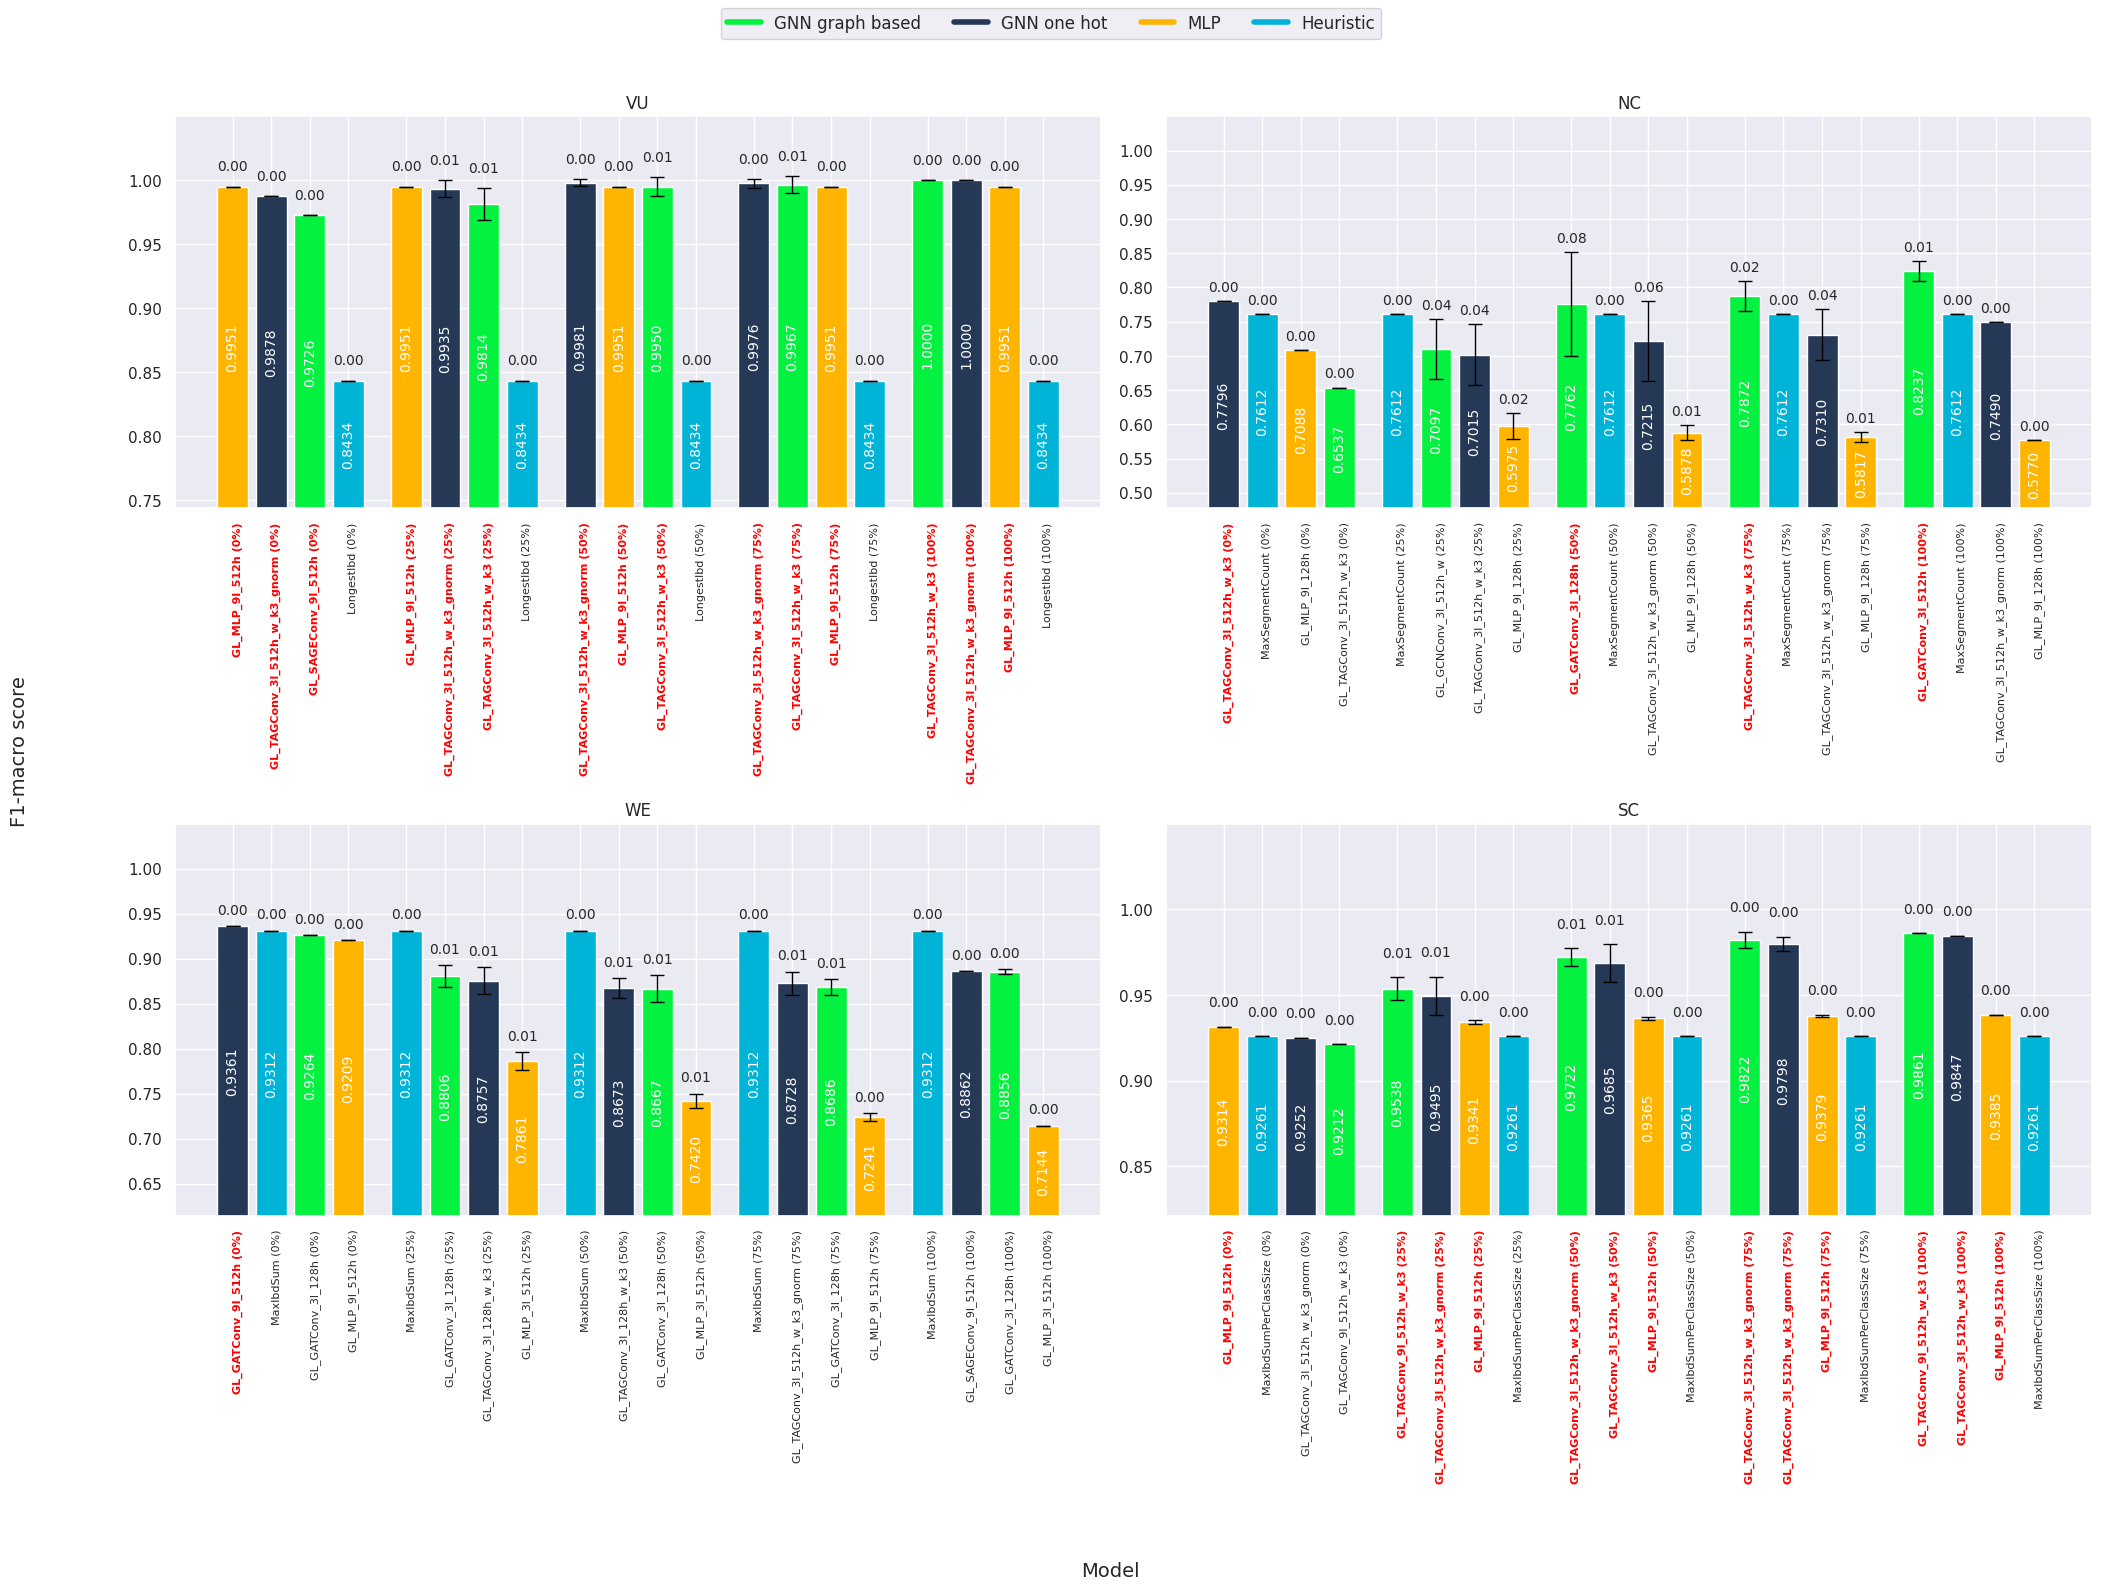

In [57]:
visualize_classifier_data_all_masks(['/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_0',
                                     '/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_25',
                                     '/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_50',
                                     '/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_75',
                                     '/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_mask_100'], sort_bars=True, annotate=True, mask_percent='all', fig_path='/mnt/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)

### No masks, base scores

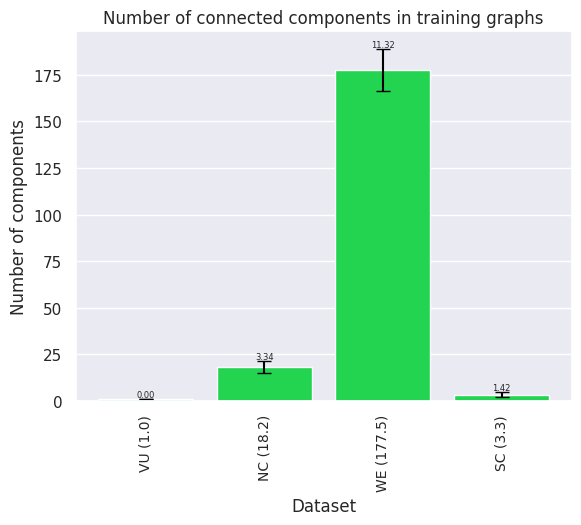

/tmp/ipykernel_2193512/3731227491.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2193512/3731227491.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2193512/3731227491.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(one_best_model_per_class_df.Classifier, rotation=90, ha='right', rotation_mode='anchor', fontsize=8)
/tmp/ipykernel_2193512/3731227491.py:241: UserWarning: set_ticklabels() should only be used with a fixed n

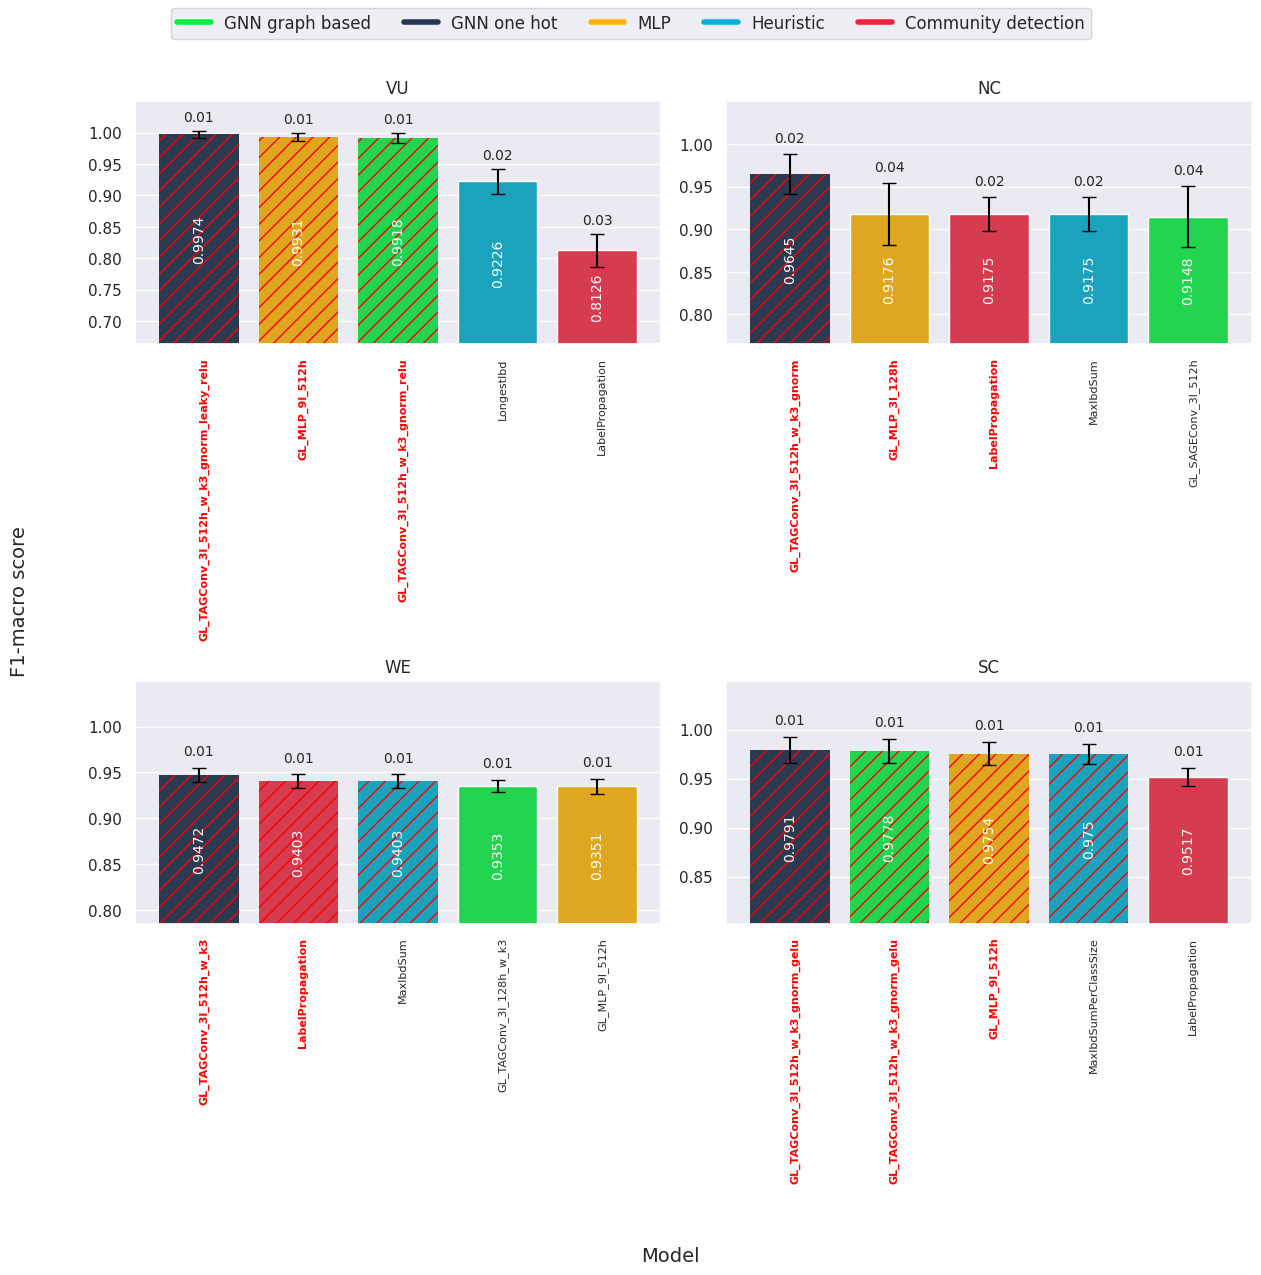

In [58]:
visualize_classifier_data('/mnt/10tb/home/shmelev/GENLINK/downstream_tasks/runs/real_data_no_mask', sort_bars=True, annotate=True, mask_percent='no', fig_path='/mnt/10tb/home/shmelev/GENLINK/pictures/main_pictures', plot_best_per_class=True)